In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import log_Gamma_2_eta
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_delta_2_eta0
from helper_funcs import logdotexp

# Load in Data

In [42]:
# load in data
df = pd.read_csv("../dat/Killer_Whale_Data.csv")
df["stime"] = pd.to_datetime(df["stime"])

# populate data object
data = []
for row in df.iterrows():
    data.append({'delt_d' : row[1]['delt_d'],
                 'e_dive' : row[1]['e_dive']})

# Load in the HMM

In [3]:
# define paths 
date = "2023-04-14"
param_folder = "../params/case_study/updown/" + date
plot_folder = "../plt/case_study/updown/" + date
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

# set parameters
methods = ["control","BFGS","SAGA","SVRG","GD","CG"]
K = [3,3]
partial_Es = [0.0,0.5,1.0]
tol = 1e-2

# initialize variables
optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

In [34]:
# load in HMM for each method
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            best_fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(50):
                
                fname = param_folder + "/case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                with open(fname, 'rb') as f:
                    optim = pickle.load(f)
                if len(optim.time_trace) == 0:
                    continue
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname

5.796426496208046
5.788081869301784
0.6215647213590706
0.0008637040529423742
0.1279384283529369
0.4664568002676941
3.1521015228016447
0.16642212644023432
3.550206884222052
0.1164802021253475
0.0008636455441627731
5.942552023462087
0.17541961996035646
0.0002635773633002999
5.797424634665231
7.576500025924476
0.05661350690102247
0.007909053180787553
0.42100745572831383
5.796433266863643
1.7068184377559963
0.0008503115459283865
0.16775129896304763
0.0008644777305085035
0.006337222258136093
0.44222474510817056
0.16768092572132423
0.0008700924254165323
0.0008638745617801421
0.4540971427366354
0.09734010567646298
1.3496926233817428
3.20222650676525
0.12795200096746356
5.72048859769386
0.0008637665653592801
0.1427463695329889
0.17541996607680851
1.7425555472228116
5.795350893244551
0.0008640116858227057
0.15300763598260025
0.17541845962394428
1.7957860077864023
0.9400092015488468
3.2032532274217753
0.17830085432897297
3.2079281658716656
0.029474242386972355
0.13238524696605816
8.6170830267941

1.072593802041091
1.3369549675501498
0.10130255825238196
0.7702307620918214
2.668782470489623
0.362728875668569
0.10094935211935104
7.186864262634257
0.27290078760397984
0.10652559713788548
27.575405174152284
2.4140391604034184
0.07003018034975733
0.14488627733455772
0.08378084749337063
0.12417203693325551
1.8093222599243937
1.136522717116099
7236.229046617747
0.4526849608898411
0.13596039928740292
0.4766513556152069
0.508543676852397
1.7871540880945596
33236.984369790924
0.10221554171547118
21.630083938613186
0.07466738700274449
0.10426885844747782
0.7298618390379666
145.34249380195217
0.634835899752408
8.237990025516268
0.4986318449786706
0.16132987021510822
0.001366163971588776
2.7135002043477763
6.271507665856402
0.0002897957972264589
0.11013644912783857
0.1910385128527584
0.7686784465702354
0.6005316055565435
8.6638116287845
0.11305297696689598
1.4212581025686752
5.210180134746947
0.0820064377657266
0.15172874008731485
1.4993104708247813
2.9477604917702
2.620800827419187
0.0107360

In [12]:
# find best HMM
max_ll = -np.infty
for key,optim in optims.items():
    if optim.log_like_trace[-1] > max_ll:
        self = optim
        max_ll = optim.log_like_trace[-1]

('control', 0.0)
-0.53983286078892
('SAGA', 1.0)
-0.482842292184391
('SVRG', 1.0)
-0.48272970079542293


# Unnormalize $\theta$

In [36]:
# get mean and standard deviation of data to unnormalize theta
x_bar = df['delt_d'].mean()
s = df['delt_d'].std()

for i in range(K[0]):
    self.theta[i]['delt_d']['mu'] = x_bar + s*self.theta[i]['delt_d']['mu']
    self.theta[i]['delt_d']['log_sig'] = np.log(s) + self.theta[i]['delt_d']['log_sig']

# Repopulate the parameters

In [37]:
self.data = data

self.log_alphas = np.zeros((self.T,self.K_total))
self.log_betas = np.zeros((self.T,self.K_total))

# p_Xt and p_Xtm1_Xt
self.p_Xt = np.zeros((self.T,self.K_total))
self.p_Xtm1_Xt = np.zeros((self.T,self.K_total,self.K_total))

# gradients wrt theta
self.grad_theta_t = [deepcopy(self.theta) for _ in range(self.T)]
self.grad_theta = deepcopy(self.theta)

# gradients wrt eta
self.grad_eta_t = [deepcopy(self.eta) for _ in range(self.T)]
self.grad_eta = deepcopy(self.eta)

# gradients wrt eta0
self.grad_eta0_t = [deepcopy(self.eta0) for _ in range(self.T)]
self.grad_eta0 = deepcopy(self.eta0)

# perform an E step
self.E_step()
self.get_log_Gamma(jump=False)
self.get_log_Gamma(jump=True)
self.get_log_delta()

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


array([  -1.35395001, -101.35395001, -101.35395001,   -6.4257933 ,
       -106.4257933 , -106.4257933 ,   -0.30088556, -100.30088556,
       -100.30088556])

# Plot emission distributions with error bounds

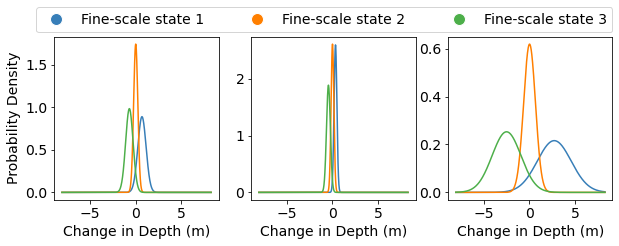

In [38]:
# set ploting parameters
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]
K_total = self.K[1]*self.K[0]
    
# get bounds
min_mu = np.min([theta_fine['delt_d']['mu'] for theta_fine in self.theta])
max_mu = np.max([theta_fine['delt_d']['mu'] for theta_fine in self.theta])
max_sig = np.exp(np.max([theta_fine['delt_d']['log_sig'] for theta_fine in self.theta]))


# initialize figure
fig,ax = plt.subplots(1,3,figsize=(10,3))

# define x and y
x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
y = np.zeros((1000,K_total))

# get densities
mu = np.concatenate([theta_fine['delt_d']['mu'] for theta_fine in self.theta])
sig = np.exp(np.concatenate([theta_fine['delt_d']['log_sig'] for theta_fine in self.theta]))
for state in range(K_total):
    y[:,state] = norm.pdf(x,mu[state],sig[state])

# plot densites
for fignum,k0 in enumerate(range(self.K[0])):
    for k1 in range(self.K[1]):

        # define state:
        state = fignum*self.K[1] + k1

        # plot distribution
        ax[fignum].plot(x,y[:,state],color=fine_colors[k1])

    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density",fontsize=14)

    ax[fignum].set_xlabel('Change in Depth (m)',fontsize=14)
    ax[fignum].tick_params(axis='both', which='major', labelsize=14)
        
leg_labels = ['Fine-scale state %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,
           prop={'size': 14}, 
           ncol=self.K[1], 
           mode="expand", 
           borderaxespad=0.,
           bbox_to_anchor=(0.1, 0.9, 0.8, .1),
           loc='lower left')

fig.savefig(plot_folder+'/emission_dists_K_%d_%d.png' % (self.K[0],self.K[1]),
            dpi=300,
            bbox_inches='tight')

# Plot Dive Profiles

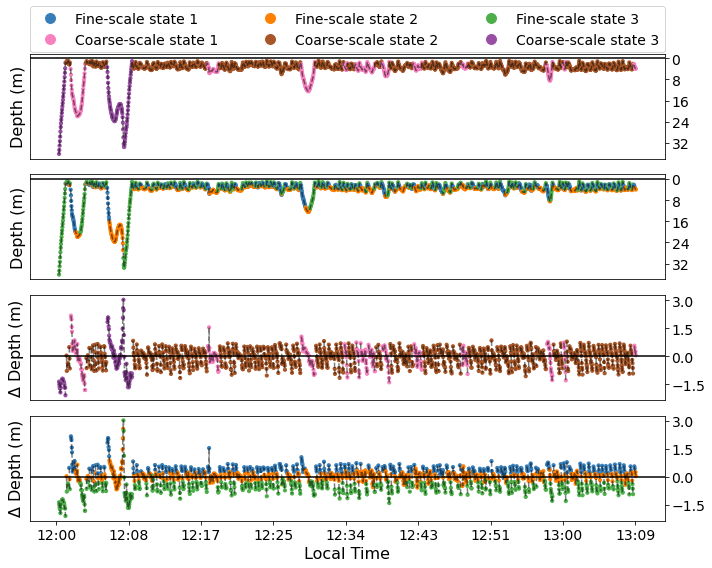

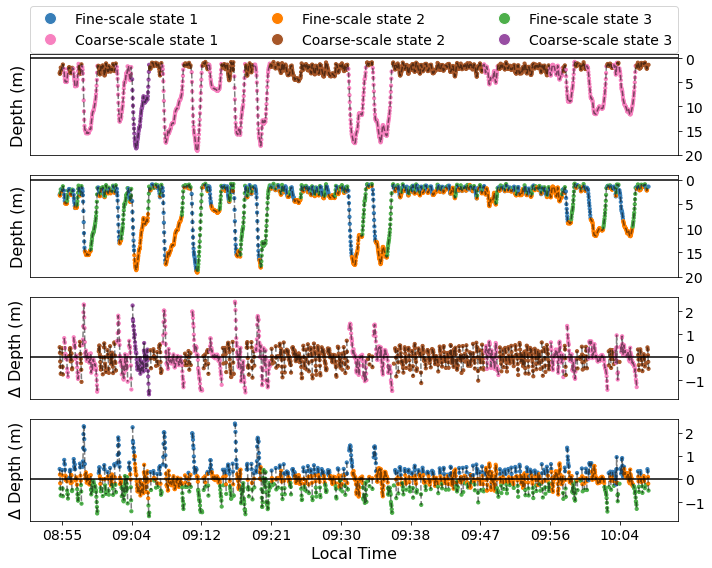

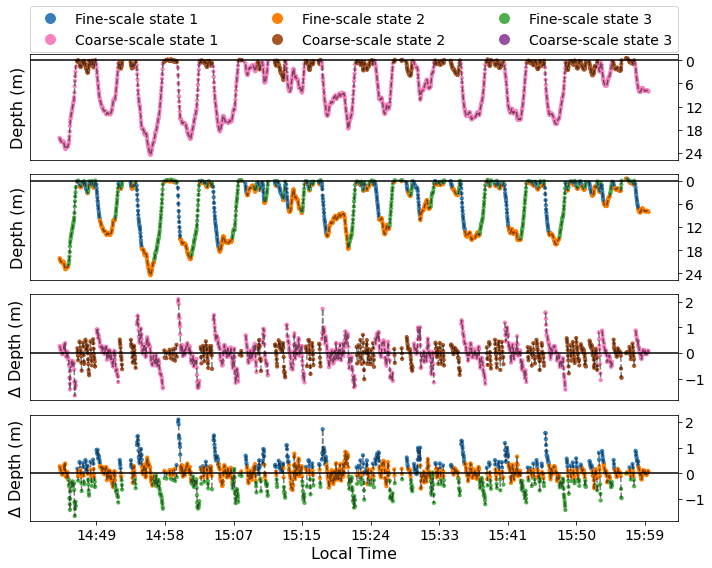

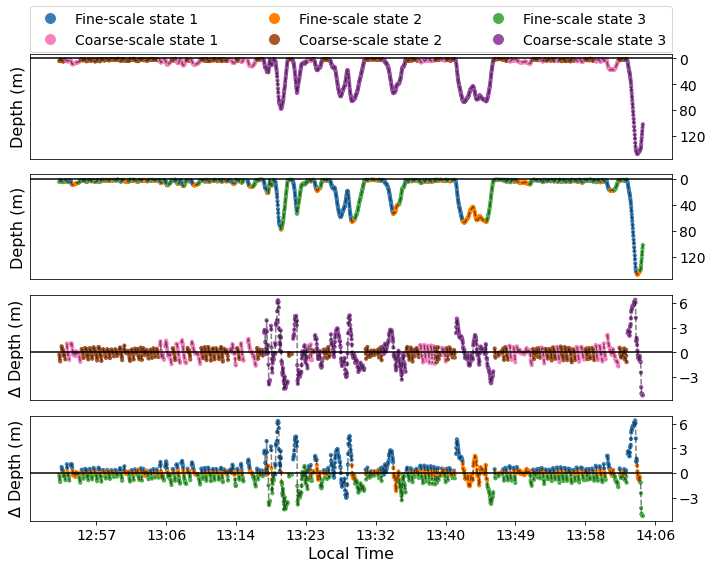

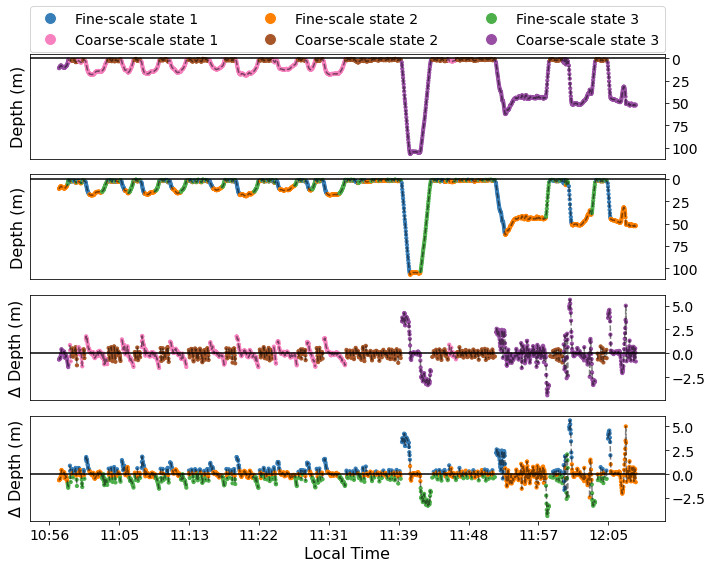

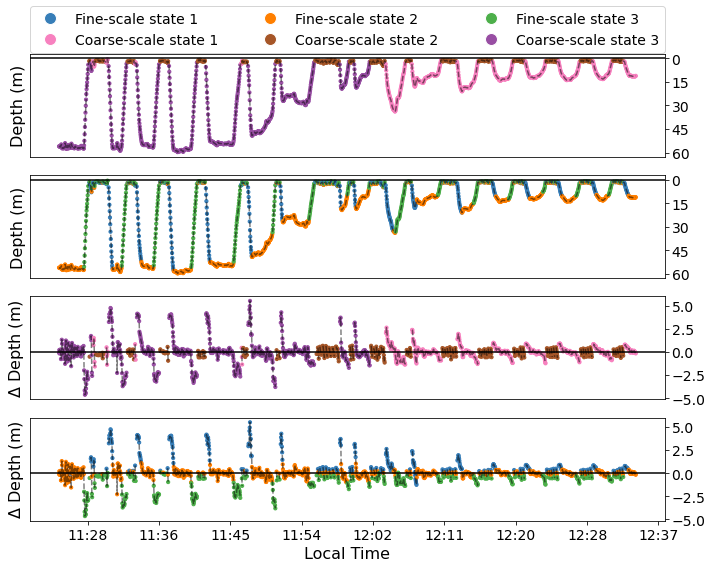

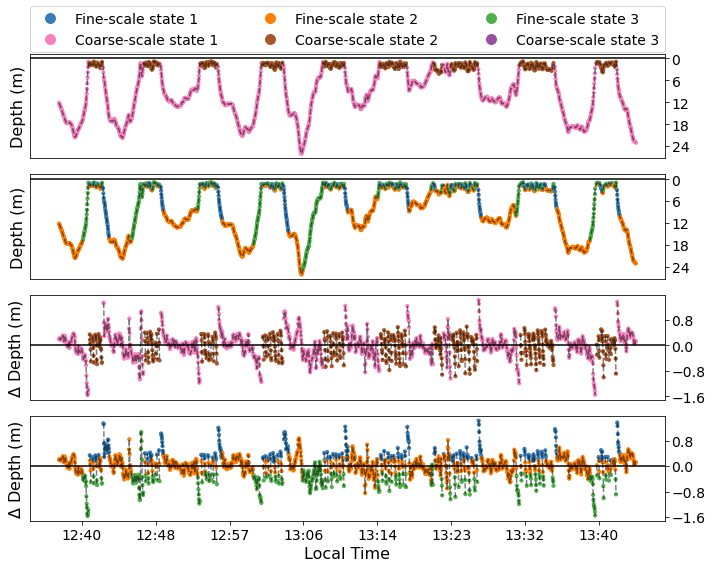

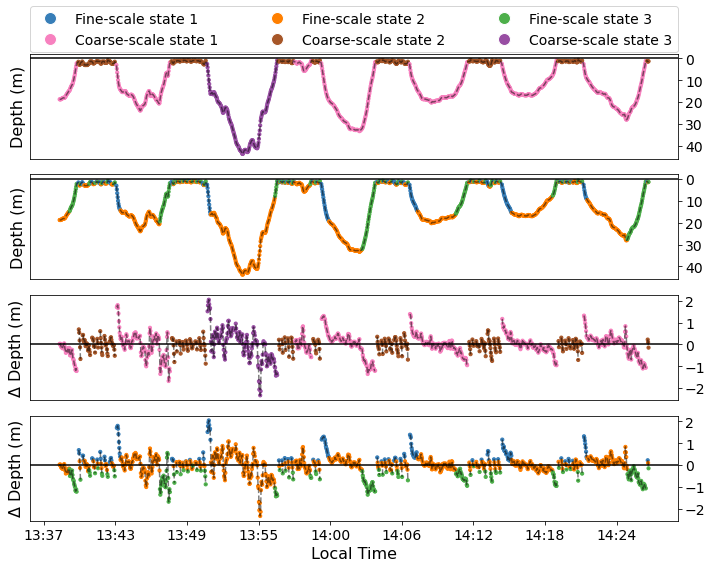

In [39]:
# select first and last time index (1hr)
sseg = 900
eseg = sseg + 1800

# plotting parameters
size = 10
figsize = (10,8)

# get p_coarse and p_fine
self.p_fine = np.zeros((self.T,self.K[1]))
for k1 in range(self.K[1]):
    self.p_fine[:,k1] = np.sum(self.p_Xt[:,k1::self.K[1]],1)
    
self.p_coarse = np.zeros((self.T,self.K[0]))
for k0 in range(self.K[0]):
    self.p_coarse[:,k0] = np.sum(self.p_Xt[:,(k0*self.K[1]):((k0+1)*self.K[1])],1)

for whale in df["ID"].unique():

    df0 = df[df["ID"] == whale].reset_index().drop("index",axis=1).reset_index()
    df0 = df0[sseg:eseg]

    # get the dive types
    ML_subdivetype = np.argmax(self.p_fine[df["ID"] == whale,:],1)[sseg:eseg]
    ML_divetype = np.argmax(self.p_coarse[df["ID"] == whale,:],1)[sseg:eseg]

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in ML_divetype]
    fine_colors = [CB_color_cycle[i] for i in ML_subdivetype]

    fig,ax = plt.subplots(4,1,figsize=figsize)

    # get legend
    leg_labels = ['Dive Phase %d'%(i+1) for i in range(self.K[1])] + \
                 ['Dive Type %d'%(i+1) for i in range(self.K[0])]
    
    leg_labels = ['Fine-scale state %d'%(i+1) for i in range(self.K[1])] + \
                 ['Coarse-scale state %d'%(i+1) for i in range(self.K[1])]
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[0],
                              markerfacecolor=CB_color_cycle[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[3],
                              markerfacecolor=CB_color_cycle[3], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[1],
                              markerfacecolor=CB_color_cycle[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[4],
                              markerfacecolor=CB_color_cycle[4], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[2],
                              markerfacecolor=CB_color_cycle[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[5],
                              markerfacecolor=CB_color_cycle[5], markersize=12)]


    ax[0].plot(df0['stime'],df0['depth'],'k--',alpha=0.5)
    ax[0].axhline(0,color='k')
    ax[0].scatter(df0['stime'],df0['depth'],c=coarse_colors,s=size)
    
    ax[1].plot(df0['stime'],df0['depth'],'k--',alpha=0.5)
    ax[1].axhline(0,color='k')
    ax[1].scatter(df0['stime'],df0['depth'],c=fine_colors,s=size)
    
    ax[2].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[2].axhline(0,color='k')
    ax[2].scatter(df0['stime'],df0['delt_d'],c=coarse_colors,s=size)
    
    ax[3].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[3].axhline(0,color='k')
    ax[3].scatter(df0['stime'],df0['delt_d'],c=fine_colors,s=size)

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[0].invert_yaxis()
    ax[1].set_ylabel('Depth (m)',fontsize=16)
    ax[1].invert_yaxis()
    ax[2].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)
    ax[3].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)

    ax[-1].set_xlabel("Local Time",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d.png'%(whale,self.K[0],self.K[1]),dpi=300)
    plt.show()